In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def cfl_adv_burger(a,x): 
    """
    Computes the dt_fact, i.e., Courant, Fredrich, and 
    Lewy condition for the advective term in the Burger's eq. 

    Parameters
    ----------
    a : `float` or `array`
        Either constant, or array which multiply the right hand side of the Burger's eq.
    x : `array`
        Spatial axis. 

    Returns
    ------- 
    `float`
        min(dx/|a|)
    """
    return np.min(np.gradient(x)/np.abs(a))

def deriv_dnw(xx, hh, **kwargs):
    """
    Returns the non-centered 1st order forward derivative of hh respect to xx. 

    Parameters 
    ----------
    xx : `array`
        Spatial axis. 
    hh : `array`
        Function that depends on xx. 

    Returns
    -------
    `array`
        The non-centered 1st order forward derivative of hh respect to xx. 
        Last point is ill calculated. 
    """
    if "ddx_order" in kwargs:
        order = kwargs["ddx_order"]
    else:
        order = 1

    dx = np.roll(xx, -1) - xx
    
    if order == 1:
        return (np.roll(hh, -1) - hh)/dx
    
    elif order == 2:
        return (-np.roll(hh, -2) + 4 * np.roll(hh, -1) - hh)/dx
    
    else:
        raise ValueError('Order not implemented')
    

def central_second(xx, hh, **kwargs):
    """
    Returns the centered second derivative of hh respect to xx. 

    Parameters 
    ----------
    xx : `array`
        Spatial axis. 
    hh : `array`
        Function that depends on xx. 

    Returns
    -------
    `array`
        The centered second derivative of hh respect to xx. 
        Last point is ill calculated. 
    """

    if "ddx_order" in kwargs:
        order = kwargs["ddx_order"]
    else:
        order = 1

    dx = np.roll(xx, -1) - xx
    
    if order == 1:
        return (np.roll(hh, -1) - 2 * hh + np.roll(hh, 1))/(dx**2)
    
    elif order == 2:
        return (-np.roll(hh, -2) + 16 * np.roll(hh, -1) - 30 * hh + 16 * np.roll(hh, 1) - np.roll(hh, 2))/(12 * dx**2)
    
    else:
        raise ValueError('Order not implemented')

def step_adv_burgers(xx, hh, a, cfl_cut = 0.98, 
                    ddx = lambda x,y: deriv_dnw(x, y), **kwargs): 
    r"""
    Right hand side of Burger's eq. where a can be a constant or a function that 
    depends on xx. 

    Requires 
    ---------- 
    cfl_adv_burger function which computes np.min(dx/a)

    Parameters
    ----------
    xx : `array`
        Spatial axis. 
    hh : `array`
        Function that depends on xx.
    a : `float` or `array`
        Either constant, or array which multiply the right hand side of the Burger's eq.
    cfl_cut : `float`
        Constant value to limit dt from cfl_adv_burger. 
        By default clf_cut=0.98. 
    ddx : `lambda function`
        Allows to select the type of spatial derivative. 
        By default lambda x,y: deriv_dnw(x, y)

    Returns
    -------
    `array` 
        Time interval.
        Right hand side of (u^{n+1}-u^{n})/dt = from burgers eq, i.e., x \frac{\partial u}{\partial x} 
    """
    dt = cfl_cut * cfl_adv_burger(a, xx)

    return dt, - a * ddx(xx, hh, **kwargs) + 0.5 * central_second(xx, hh, **kwargs)

def evolv_adv_burgers(xx, hh, nt, a, cfl_cut = 0.98, 
        ddx = lambda x,y: deriv_dnw(x, y), 
        bnd_type='wrap', bnd_limits=[0,1], **kwargs):
    r"""
    Advance nt time-steps in time the burger eq for a being a a fix constant or array.
    Requires
    ----------
    step_adv_burgers

    Parameters
    ----------
    xx : `array`
        Spatial axis. 
    hh : `array`
        Function that depends on xx.
    a : `float` or `array`
        Either constant, or array which multiply the right hand side of the Burger's eq.
    cfl_cut : `float`
        Constant value to limit dt from cfl_adv_burger. 
    ddx : `lambda function`
        Allows to change the space derivative function.
        By default lambda x,y: deriv_dnw(x, y).  
    bnd_type : `string`
        Allows to select the type of boundaries. 
        By default 'wrap'.
    bnd_limits : `list(int)`
        Array of two integer elements. The number of pixels that
        will need to be updated with the boundary information. 
        By default [0,1].

    Returns
    ------- 
    t : `array`
        time 1D array
    unnt : `array`
        Spatial and time evolution of u^n_j for n = (0,nt), and where j represents
        all the elements of the domain. 
    """
    dt = cfl_cut * cfl_adv_burger(a, xx)

    tt = np.zeros(nt)
    unnt = np.zeros((nt, len(xx)))

    #setting initial values
    unnt[0,:] = hh
    tt[0] = 0

    for i in range(0,nt-1):
        #getting timestep and rhs of Burgers eq
        dt, rhs = step_adv_burgers(xx, unnt[i,:], a, ddx=ddx, cfl_cut=cfl_cut, **kwargs)
        #forwarding in time
        hh = unnt[i,:] + rhs * dt
   
        #remove ill calculated points
        if bnd_limits[1] != 0:
            hh = hh[bnd_limits[0]:-bnd_limits[1]]
        else:
            hh = hh[bnd_limits[0]:]
        #padding
        hh = np.pad(hh, pad_width=bnd_limits ,mode=bnd_type)
        unnt[i+1,:] = hh
        tt[i+1] = tt[i] + dt

    return tt, unnt

In [24]:
xx = np.linspace(0,1,80)
# hh is a velocity profile with a shock
a = np.zeros(len(xx))
a[0:40] = -1e6
a[40:] = 1e6

hh = a

nt = 500
tt, unnt = evolv_adv_burgers(xx, hh, nt, a=1, cfl_cut=0.1, bnd_limits=[0,0])

/tmp/ipykernel_2505001/2187242381.py:80: RuntimeWarning: overflow encountered in divide
  return (np.roll(hh, -1) - 2 * hh + np.roll(hh, 1))/(dx**2)
/tmp/ipykernel_2505001/2187242381.py:121: RuntimeWarning: invalid value encountered in add
  return dt, - a * ddx(xx, hh, **kwargs) + 0.5 * central_second(xx, hh, **kwargs)
/tmp/ipykernel_2505001/2187242381.py:80: RuntimeWarning: invalid value encountered in add
  return (np.roll(hh, -1) - 2 * hh + np.roll(hh, 1))/(dx**2)
/tmp/ipykernel_2505001/2187242381.py:45: RuntimeWarning: invalid value encountered in subtract
  return (np.roll(hh, -1) - hh)/dx
/tmp/ipykernel_2505001/2187242381.py:80: RuntimeWarning: invalid value encountered in subtract
  return (np.roll(hh, -1) - 2 * hh + np.roll(hh, 1))/(dx**2)


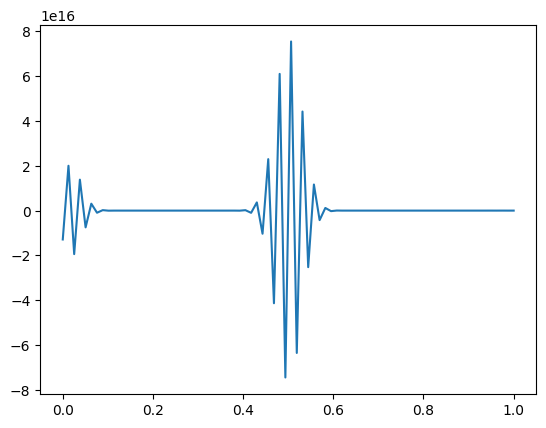

In [31]:
plt.plot(xx, unnt[10,:], label='t=0')